In [1]:
import os
from importlib import reload
from typing import List

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from serial import Serial

import spectrogram as spectrogram
import spectrum_painting as sp
import spectrum_painting_data as sp_data
import spectrum_painting_model as sp_model
import spectrum_painting_plotting as sp_plot
import spectrum_painting_predict as sp_predict
import spectrum_painting_training as sp_training
from save_iq_data_for_arduino import save_iq_data

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Convert MATLAB data to numpy files to make loading quicker

See `convert_matlab_to_numpy.py` to do call this manually without running it in the notebook.

# Load spectrograms

In [2]:
reload(sp_training)

classes = ["Z", "B", "W", "BW", "ZB", "ZW", "ZBW"]
spectrum_painting_options = sp_training.SpectrumPaintingTrainingOptions(
    downsample_resolution=64,
    k=3,
    l=16,
    d=4
)

In [3]:
# Reload spectrum painting module in case the code changed
# and you want what is executed to be what you wrote.
reload(spectrogram)
reload(sp)
reload(sp_data)

spectrograms = sp_data.load_spectrograms(data_dir="data/numpy",
                                         classes=classes,
                                         snr_list=[0],
                                         windows_per_spectrogram=256,
                                         window_length=256,
                                         nfft=256)

In [4]:
reload(sp)
reload(spectrogram)
reload(sp_plot)
reload(sp_predict)
reload(sp_training)

train_test_sets = sp_training.create_spectrum_painting_train_test_sets(
    spectrograms=spectrograms,
    label_names=classes,
    options=spectrum_painting_options,
    test_size=0.3
)

print(f"Number of training images: {len(train_test_sets.y_train)}")
print(f"Number of testing images: {len(train_test_sets.y_test)}")

Number of training images: 2464
Number of testing images: 1057


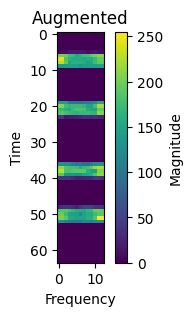

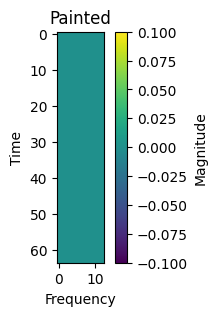

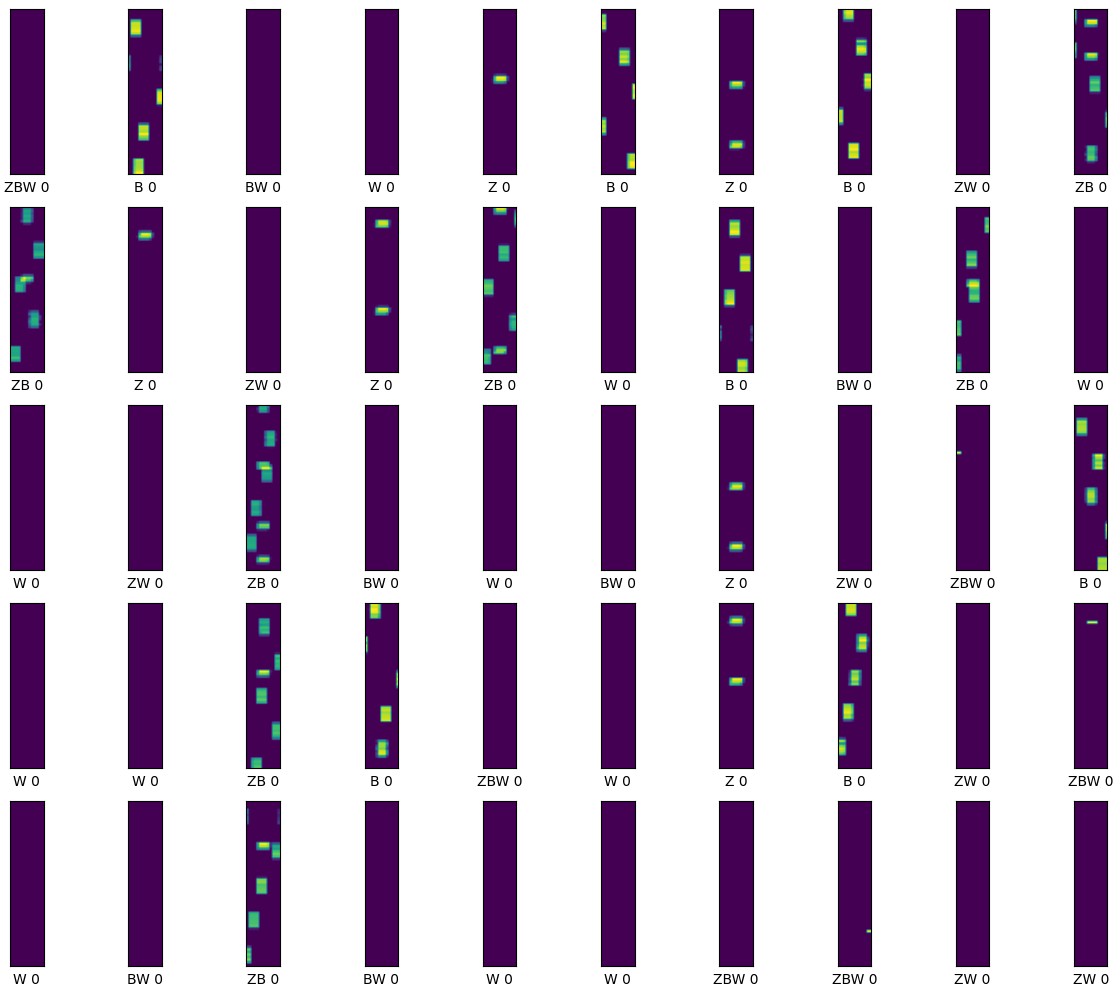

In [5]:
image_index = 30
sp_plot.plot_spectrogram(train_test_sets.x_test_augmented[image_index], "Augmented")
sp_plot.plot_spectrogram(train_test_sets.x_test_painted[image_index], "Painted")

sp_plot.plot_train_images(train_test_sets.x_test_painted,
                          train_test_sets.y_test,
                          train_test_sets.label_names,
                          train_test_sets.test_snr)

# Create TensorFlow model

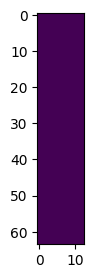

(64, 13)


2024-06-13 17:10:50.739784: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-06-13 17:10:50.740026: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-06-13 17:10:50.740045: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-06-13 17:10:50.740318: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-13 17:10:50.740895: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 13, 1)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 64, 13, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 13, 2)            20        ['input_1[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 64, 13, 2)            20        ['input_2[0][0]']             
                                                                                              

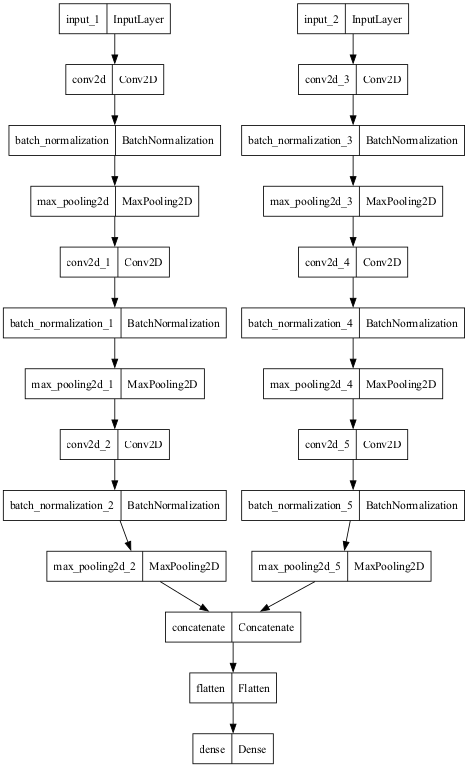

In [6]:
reload(sp_model)

plt.figure(figsize=(3, 3))
plt.imshow(train_test_sets.x_test_painted[0], cmap='viridis')
plt.show()

image_shape = train_test_sets.x_train_augmented[0].shape
print(image_shape)

tf_model = sp_model.create_tensorflow_model(image_shape=image_shape, label_count=len(train_test_sets.label_names))
tf_model.summary()
tf.keras.utils.plot_model(tf_model, to_file="output/model.png", dpi=60)


# Train the TensorFlow model

2024-06-13 17:10:51.757262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 Epoch: 116, Val. accuracy = 0.9053926467895508

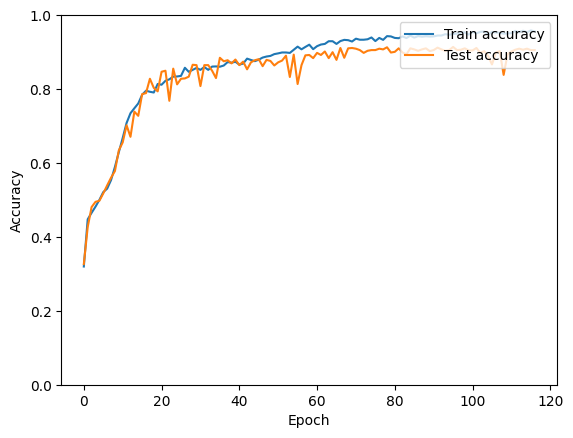

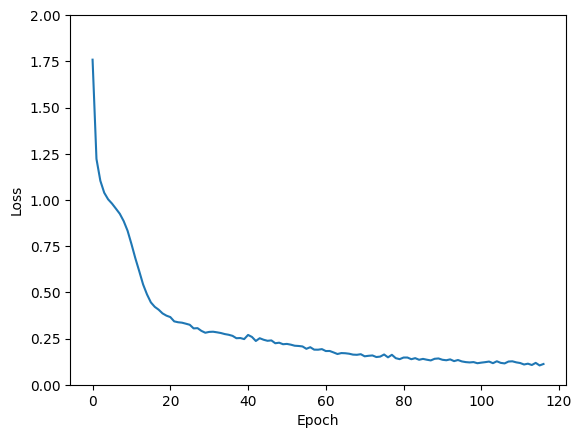

Final loss: 0.238853, final accuracy: 0.905393


In [7]:
reload(sp_model)
history = sp_model.fit_model(tf_model, train_test_sets, epochs=200, early_stopping_patience=20)

sp_plot.plot_model_accuracy_epochs(history)
sp_plot.plot_model_loss(history)

final_loss, full_model_accuracy = tf_model.evaluate([train_test_sets.x_test_augmented,
                                                     train_test_sets.x_test_painted],
                                                    train_test_sets.y_test,
                                                    verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, full_model_accuracy))


In [8]:
output_file = f"output/spectrum-painting-model.keras"

# tf.saved_model.save(tf_model, "output/")
tf_model.save(output_file, save_format="keras")

keras_model_size = os.stat(output_file).st_size
print(f"Done. Keras model size = {keras_model_size // 1000} KB")

Done. Keras model size = 85 KB


# Confusion matrix for TensorFlow model

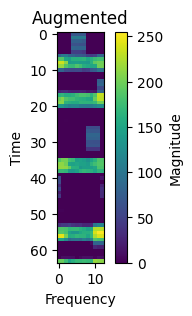

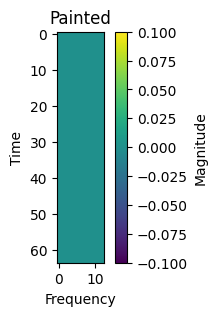

BW


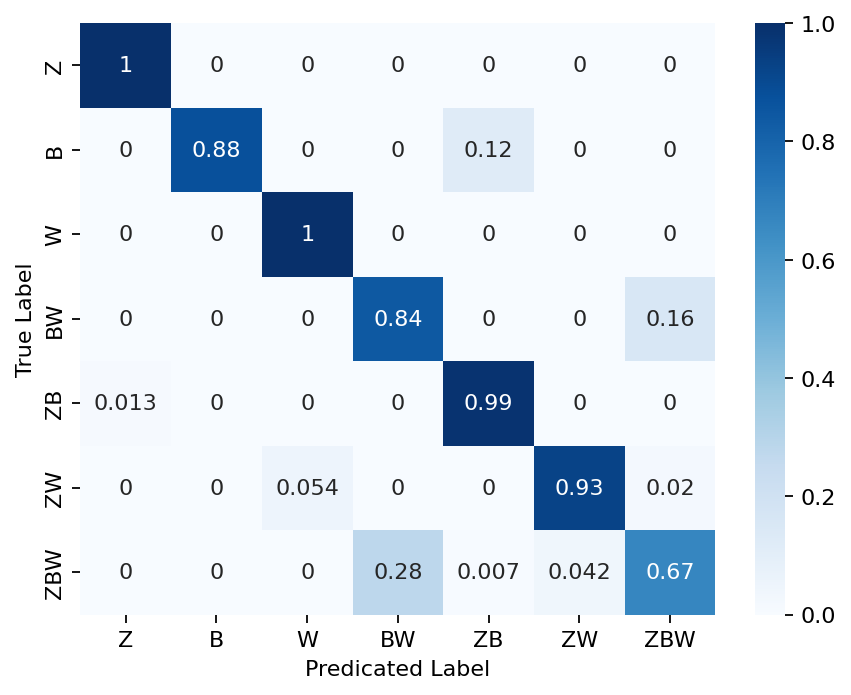

In [9]:
reload(sp_predict)
reload(sp_plot)

# Predict with full Tensorflow
test_img_augmented = train_test_sets.x_test_augmented[17]
test_img_painted = train_test_sets.x_test_painted[17]

sp_plot.plot_spectrogram(test_img_augmented, "Augmented")
sp_plot.plot_spectrogram(test_img_painted, "Painted")

prediction = sp_predict.predict_full_model(tf_model, test_img_augmented, test_img_painted)

print(train_test_sets.label_names[prediction])

tf_model_y_predictions = [sp_predict.predict_full_model(tf_model, x_a, x_p) for (x_a, x_p) in
                          zip(train_test_sets.x_test_augmented, train_test_sets.x_test_painted)]

sp_plot.plot_confusion_matrix(tf_model_y_predictions, train_test_sets.y_test, train_test_sets.label_names)

# Convert to Lite model

In [10]:
reload(sp_model)
tflite_model = sp_model.convert_to_tensorflow_lite(tf_model,
                                                   train_test_sets.x_test_augmented,
                                                   train_test_sets.x_test_painted)
print(f"Done. Model size = {len(tflite_model) // 1000} KB")

lite_output_file = f"output/spectrum-painting-model.tflite"
# Save the model.
with open(lite_output_file, "wb") as f:
    f.write(tflite_model)

# Create a hex dump of the model in a C file for the arduino.
# Use sed to make the variables const since they are huge.
! xxd -i $lite_output_file | sed -e "s/unsigned/const unsigned/"  > ../arduino/spectrum_painting/model.h

INFO:tensorflow:Assets written to: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmpw18bkn16/assets


INFO:tensorflow:Assets written to: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmpw18bkn16/assets
/Users/sethd/Desktop/spectrum-painting/venv/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-06-13 17:12:39.510816: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-06-13 17:12:39.510940: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-06-13 17:12:39.511460: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmpw18bkn16
2024-06-13 17:12:39.513199: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-06-13 17:12:39.513204: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/81/3wz7wxg90f3

Done. Model size = 12 KB


fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


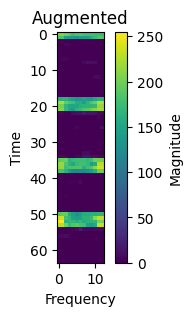

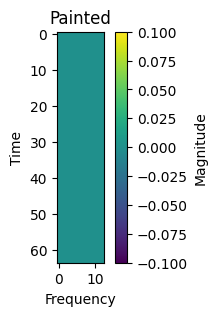

W
Prediction: W


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [11]:
reload(sp_predict)
image_index = 20

# Test with Tensorflow Lite
test_img_augmented = train_test_sets.x_test_augmented[image_index]
test_img_painted = train_test_sets.x_test_painted[image_index]

sp_plot.plot_spectrogram(test_img_augmented, "Augmented")
sp_plot.plot_spectrogram(test_img_painted, "Painted")
print(train_test_sets.label_names[train_test_sets.y_test[image_index]])

prediction = sp_predict.predict_lite_model(tflite_model, test_img_augmented, test_img_painted)
print(f"Prediction: {train_test_sets.label_names[prediction]}")

# Confusion matrix for Lite model

Lite model accuracy = 0.8987701040681173


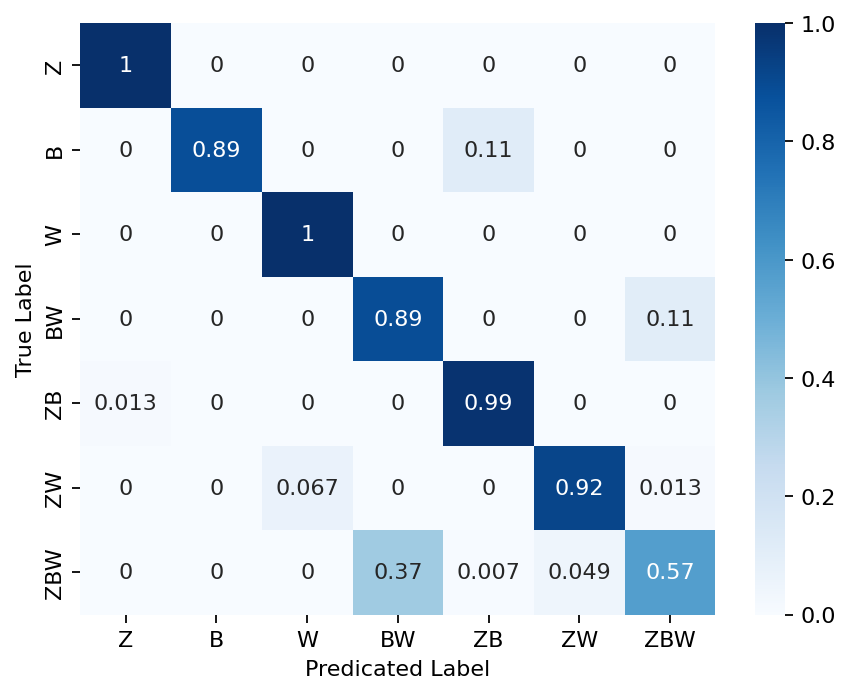

In [12]:
tflite_model_y_predictions: List[int] = []

for x_aug, x_painted in list(zip(train_test_sets.x_test_augmented, train_test_sets.x_test_painted)):
    tflite_model_y_predictions.append(sp_predict.predict_lite_model(tflite_model, x_aug, x_painted))

tflite_accuracy = np.sum(train_test_sets.y_test == tflite_model_y_predictions) / len(train_test_sets.y_test)

print(f"Lite model accuracy = {tflite_accuracy}")
sp_plot.plot_confusion_matrix(np.asarray(tflite_model_y_predictions),
                              train_test_sets.y_test,
                              train_test_sets.label_names)

# Save IQ data to the arduino

In [13]:
iq_data = np.load(f"data/numpy/SNR5_ZBW.npy")

save_iq_data(iq_data, windows=256, window_length=256, file="../arduino/spectrum_painting/data.h")

# Compile and upload to arduino

In [18]:
! arduino-cli compile --fqbn arduino:mbed:nano33ble ../arduino/spectrum_painting/spectrum_painting.ino
! arduino-cli upload --fqbn arduino:mbed:nano33ble ../arduino/spectrum_painting/spectrum_painting.ino --port /dev/cu.usbmodem21301

Library Arduino_TensorFlowLite has been declared precompiled:
Precompiled library in "/Users/sethd/Documents/Arduino/libraries/Arduino_TensorFlowLite/src/cortex-m4/fpv4-sp-d16-softfp" not found
Precompiled library in "/Users/sethd/Documents/Arduino/libraries/Arduino_TensorFlowLite/src/cortex-m4" not found
Sketch uses 492192 bytes (50%) of program storage space. Maximum is 983040 bytes.
Global variables use 126496 bytes (48%) of dynamic memory, leaving 135648 bytes for local variables. Maximum is 262144 bytes.

Used library           Version     Path
Arduino_TensorFlowLite 2.4.0-ALPHA /Users/sethd/Documents/Arduino/libraries/Arduino_TensorFlowLite
Wire                               /Users/sethd/Library/Arduino15/packages/arduino/hardware/mbed/3.3.0/libraries/Wire

Used platform Version Path
arduino:mbed  3.3.0   /Users/sethd/Library/Arduino15/packages/arduino/hardware/mbed/3.3.0


A new release of Arduino CLI is available: 0.35.3 → 1.0.0
https://arduino.github.io/arduino-cli/latest/inst

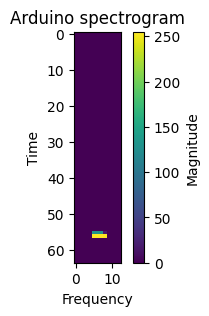

Downsample duration = 269 ms
Augment duration = 21 ms
Paint duration = 0 ms
Digitize duration = 1 ms
Inference duration = 94 ms
Total duration = 385 ms
Predicted label = ZBW



Full keras model size = 85 KB
Lite model size = 12 KB
Full model accuracy = 0.9053926467895508
Lite model accuracy = 0.8987701040681173


In [19]:
serial = Serial(port="/dev/cu.usbmodem21301", baudrate=115200, timeout=1000)

arduino_spectrogram = []
for _ in range(spectrum_painting_options.downsample_resolution):
    real_line = serial.readline().decode('utf-8').strip()
    magnitudes = list(map(float, real_line.split(',')))

    arduino_spectrogram.append(magnitudes)

downsample_duration = int(serial.readline().strip())
augment_duration = int(serial.readline().strip())
paint_duration = int(serial.readline().strip())
digitize_duration = int(serial.readline().strip())
inference_duration = int(serial.readline().strip())
total_duration = int(serial.readline().strip())
predicted_label = int(serial.readline().strip())

sp_plot.plot_spectrogram(np.asarray(arduino_spectrogram), "Arduino spectrogram")

print(f"Downsample duration = {downsample_duration} ms")
print(f"Augment duration = {augment_duration} ms")
print(f"Paint duration = {paint_duration} ms")
print(f"Digitize duration = {digitize_duration} ms")
print(f"Inference duration = {inference_duration} ms")
print(f"Total duration = {total_duration} ms")
print(f"Predicted label = {classes[predicted_label]}")
print("\n\n")
print(f"Full keras model size = {keras_model_size // 1000} KB")
print(f"Lite model size = {len(tflite_model) // 1000} KB")
print(f"Full model accuracy = {full_model_accuracy}")
print(f"Lite model accuracy = {tflite_accuracy}")

serial.close()